Time to apgoee: 9.85 s

In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, pi, atan2, asin, sqrt
import matplotlib.pyplot as plt
from scipy import integrate
from model_funcs import *

In [2]:
LSM_datafile = "LSM_LOG_20220402-132105"
SIFT1_datafile = "SIFT1_LOG_20220402_124920"
SIFT2_datafile = "SIFT2_LOG_20220402_124347"
Full_LSM_datafile = "FULL_LSM"

# Parameters
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = 3.1415
ft = 3.2884  # ft/m
ms2mph = 0.6818182*ft
gs2mph = ms2mph * 9.8

In [3]:
################## DATA FRAME ##################
datafile = '../Data/Fullscale2/' + SIFT1_datafile + '.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Accel X', 'Accel Y', 'Accel Z'
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata1 = all_time
tdata1 = tdata1 - all_time[0]

ax_vn1 = df['LinearAccelNed X']
ay_vn1 = df['LinearAccelNed Y']
az_vn1 = df['LinearAccelNed Z']

In [4]:
################## DATA FRAME ##################
datafile = '../Data/Fullscale2/' + SIFT2_datafile + '.csv'
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
################## INIT VECTORS ##################
all_time = df['Timestamp'].values
tdata2 = all_time
tdata2 = tdata2 - all_time[0]
ax_vn2 = df['LinearAccelNed X']
ay_vn2= df['LinearAccelNed Y']
az_vn2 = df['LinearAccelNed Z']

## Post Drogue

In [5]:
def calc_moving_avg(axg21t, n, tdata21, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80):        
    if dynamic_window:
        axg21s_1 = pd.Series(axg21t[0:dynamic_n_timing]).rolling(window=n).mean().iloc[n-1:].values
        axg21s_2 = pd.Series(axg21t).rolling(window=dynamic_n).mean().iloc[n-1:].values[dynamic_n_timing:]
        new_axg21s = list(axg21s_1) + list(axg21s_2)
    else:
        axg21s = pd.Series(axg21t).rolling(window=n).mean().iloc[n-1:].values
        new_axg21s = list(axg21s)
    while len(new_axg21s) < len(tdata21):
        new_axg21s = [0] + list(new_axg21s) + [0]
    return new_axg21s

In [6]:
def nasa_pres(P, P0, T0, R, B, g):
        imu_temp = T0*(P/P0)**(R*B/g)
        imu_alt = (T0 - imu_temp)/B
        return imu_alt

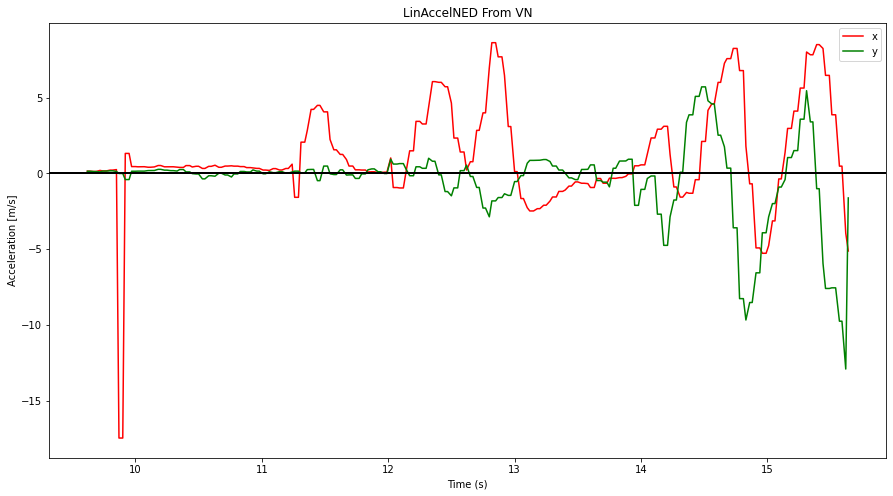

In [8]:
start_main = 380
end_main = 620

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata2[start_main:end_main], ax_vn2[start_main:end_main], color='red', label='x')
l2 = ax.plot(tdata2[start_main:end_main], ay_vn2[start_main:end_main], color='green', label='y')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
#plt.ylim((-2, 2))

ax.legend()
plt.show()

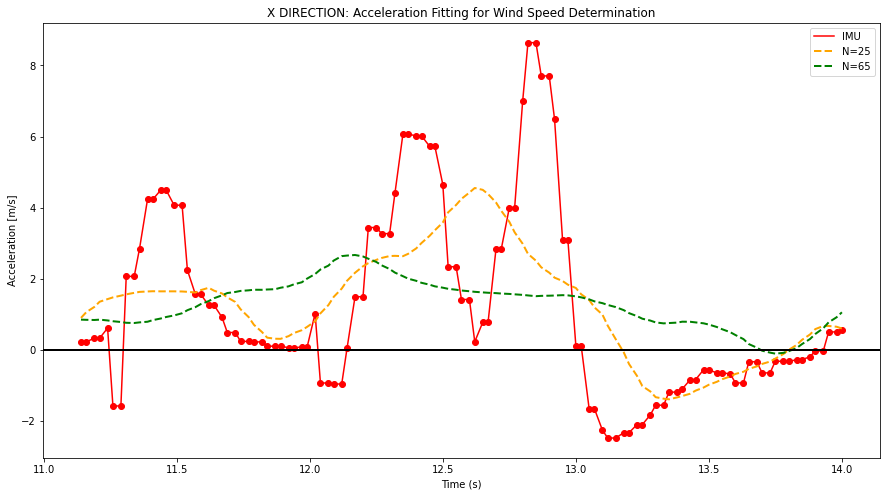

Estimated Wind Speed via Original IMU Signal: 92.13302982 mph
Estimated Wind Speed via Moving Average (25): 95.09705509 mph
Estimated Wind Speed via Moving Average (65): 96.58091337 mph


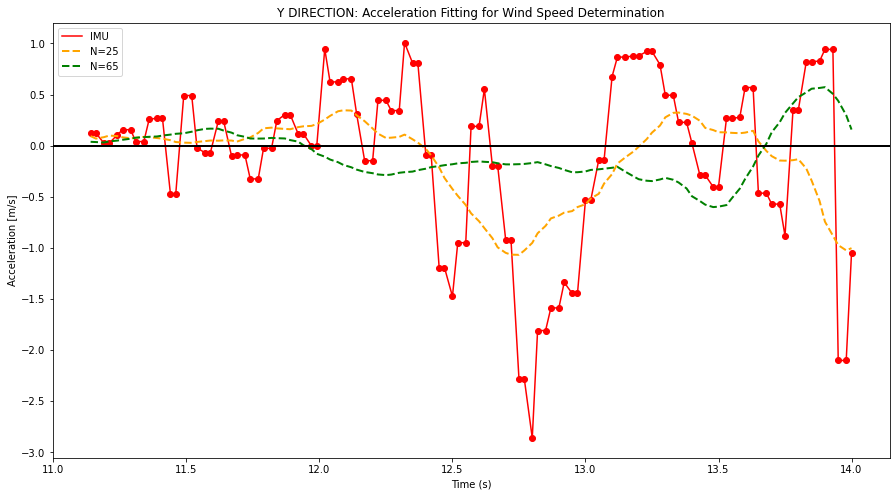

Estimated Wind Speed via Original IMU Signal: -7.37061182 mph
Estimated Wind Speed via Moving Average (25): -10.21694297 mph
Estimated Wind Speed via Moving Average (65): -6.49022418 mph


In [15]:
#calculate moving average
#dynamic_window=False, dynamic_n_timing=140, dynamic_n=80
axg21t = calc_moving_avg(ax_vn2, 25, tdata2)
new_axg21s_25 = axg21t[440:555]
#new_axg21s_45 = calc_moving_avg(axg21t, 45, tdata21)
axg21t = calc_moving_avg(ax_vn2, 65, tdata2)
new_axg21s_65 = axg21t[440:555]
#new_axg21s_85 = calc_moving_avg(axg21t, 85, tdata21)

axg21t = ax_vn2[440:555] #620
tdata21 = tdata2[440:555]
dt = tdata2[1]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, axg21t, color='red', label='IMU')
l2 = ax.scatter(tdata21, axg21t, color='red')
l25 = ax.plot(tdata21, new_axg21s_25, color='orange', label='N=25', linewidth=2, linestyle="--")
#l45 = ax.plot(tdata21, new_axg21s_45, color='blue', label='N=45', linewidth=2, linestyle="--")
l65 = ax.plot(tdata21, new_axg21s_65, color='green', label='N=65', linewidth=2, linestyle="--")
#l85 = ax.plot(tdata21, new_axg21s_85, color='purple', label='N=85', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("X DIRECTION: Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
#plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

#scipy.integrate.
result_trapz_IMU = integrate.trapz(axg21t, dx=dt)
result_trapz_MA25 = integrate.trapz(new_axg21s_25, dx=dt)
result_trapz_MA65 = integrate.trapz(new_axg21s_65, dx=dt)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMU:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (65): {gs2mph*result_trapz_MA65:.8f} mph")

#############################################################################################################

#calculate moving average
#dynamic_window=False, dynamic_n_timing=140, dynamic_n=80
axg21t = calc_moving_avg(ay_vn2, 25, tdata2)
new_axg21s_25 = axg21t[440:555]
#new_axg21s_45 = calc_moving_avg(axg21t, 45, tdata21)
axg21t = calc_moving_avg(ay_vn2, 65, tdata2)
new_axg21s_65 = axg21t[440:555]
#new_axg21s_85 = calc_moving_avg(axg21t, 85, tdata21)

axg21t = ay_vn2[440:555] #620
tdata21 = tdata2[440:555]
dt = tdata2[1]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata21, axg21t, color='red', label='IMU')
l2 = ax.scatter(tdata21, axg21t, color='red')
l25 = ax.plot(tdata21, new_axg21s_25, color='orange', label='N=25', linewidth=2, linestyle="--")
#l45 = ax.plot(tdata21, new_axg21s_45, color='blue', label='N=45', linewidth=2, linestyle="--")
l65 = ax.plot(tdata21, new_axg21s_65, color='green', label='N=65', linewidth=2, linestyle="--")
#l85 = ax.plot(tdata21, new_axg21s_85, color='purple', label='N=85', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Y DIRECTION: Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
#plt.ylim((-1.1, 1.1))

ax.legend()
plt.show()

result_trapz_IMU = integrate.trapz(axg21t, dx=dt)
result_trapz_MA25 = integrate.trapz(new_axg21s_25, dx=dt)
result_trapz_MA65 = integrate.trapz(new_axg21s_65, dx=dt)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMU:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25:.8f} mph")
print(f"Estimated Wind Speed via Moving Average (65): {gs2mph*result_trapz_MA65:.8f} mph")

(24, 414, 454, 2007, [0.8370176, 0.003601620000000004])


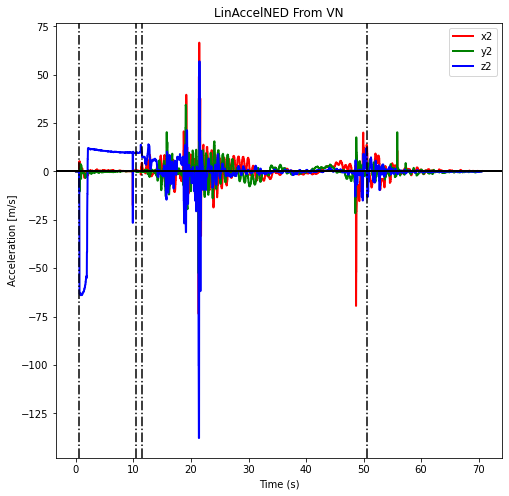

In [10]:
a_vec = [ax_vn2, ay_vn2, az_vn2]

takeoff_idx, drogue_idx, post_drogue_idx, landing_idx, a_1 = find_peak_and_wait(a_vec, tdata2, thresh=50, post_drogue_delay=1, signal_length=3, time=1, t_sim_drogue=9.85, t_sim_landing=50)
print((takeoff_idx, drogue_idx, post_drogue_idx, landing_idx, a_1))

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l3 = ax.plot(tdata2, ax_vn2, color='red', label='x2', linewidth=2)
l3 = ax.plot(tdata2, ay_vn2, color='green', label='y2', linewidth=2)
l3 = ax.plot(tdata2, az_vn2, color='blue', label='z2', linewidth=2)
l5 = plt.axhline(y=0, color='black', linewidth=2)
#l6 = plt.axvline(tdata2[a1], color='red', linestyle='--')
l6 = plt.axvline(tdata2[takeoff_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2[drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2[post_drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2[landing_idx], color='black', linestyle='-.')

#ax.fill_between(x, 0, 1, where=,
#                color='green', alpha=0.5)

ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
ax.legend()
plt.show()

In [ ]:
def find_peak_and_wait(a_vec, t, thresh=40, post_drogue_delay=1, signal_length=3, time=1, t_sim_drogue=9.85, t_sim_landing=90):
    '''
    USE Z FOR DETECTION BUT THE SIGNAL WE WANT IS IN X AND Y
    '''
    axn, ayn, azn = np.array(a_vec[0], float), np.array(a_vec[1], float), np.array(a_vec[2], float)
        
    if time==0:
        above_threshold = abs(azn) > thresh
        takeoff_idx = list(above_threshold).index(True)

        # Get past the full takeoff spike
        post_takeoff_idx = takeoff_idx
        if azn[post_takeoff_idx] > 0:
            flip = -1
        else:
            flip = 1
        takeoff_offset = 0
        while (azn[post_takeoff_idx]*flip < 0):
            post_takeoff_idx += 1
        
        # NOW FIND DROGUE
        above_threshold = abs(azn[post_takeoff_idx:]) > thresh
        takeoff_idx = list(above_threshold).index(True)
        
        # Fix this for fullscale.  Subscale won't work cause there's not actual drogue spike
        ########################################################################
        # Now get past the transcience
        while t[past_takeoff_idx] < t[takeoff_idx+takeoff_offset]:
            past_takeoff_idx += 1

        end_drogue_idx = drogue_idx
        while t[end_drogue_idx] < (t[drogue_idx] + signal_length):
            end_drogue_idx += 1
            
        ax_1 = np.average(axn[drogue_idx:end_drogue_idx])
        ay_1 = np.average(ayn[drogue_idx:end_drogue_idx])
        a_1 = [ax_1, ay_1]
            
        landing_idx = end_drogue_idx
        while t[landing_idx] < t_sim_landing:
            landing_idx += 1

        return takeoff_idx, drogue_idx, end_drogue_idx, landing_idx, a_1
        ########################################################################
    elif time==1:
        # Detect takeoff
        takeoff_idx = np.argmax(abs(azn)>thresh)
        drogue_idx = takeoff_idx
        
        # Wait until sim_drogue
        t_takeoff = t[takeoff_idx]
        t_drogue = t_takeoff
        while t_drogue < (t_takeoff + t_sim_drogue):
            drogue_idx += 1
            t_drogue = t[drogue_idx]
            
        # Now wait until takeoff_delay passes
        t_signal = t_drogue
        end_drogue_idx = drogue_idx
        while t_signal < (t_drogue + post_drogue_delay):
            end_drogue_idx += 1
            t_signal = t[end_drogue_idx]
            
        # Get the resting acceleration
        ax_1 = np.average(axn[drogue_idx:end_drogue_idx])
        ay_1 = np.average(ayn[drogue_idx:end_drogue_idx])
        a_1 = [ax_1, ay_1]
        
        # Find the landing based on time
        landing_idx = end_drogue_idx
        while t[landing_idx] < t_sim_landing + t_takeoff:
            landing_idx += 1
        
        return takeoff_idx, drogue_idx, end_drogue_idx, landing_idx, a_1
    else:
        print("BAD INPUT - FIX TIME PARAMETER")
        return -1, -1, -1, -1, -1

In [11]:
def calc_displacement(datafile, zero_out=False, my_thresh=50, my_post_drogue_delay=1, my_signal_length=3, use_time=True, my_t_sim_drogue=9.85, my_t_sim_landing=50):
    ms2mph = 0.6818182*ft
    gs2mph = ms2mph * 9.8
    
    # Read in the dataframe
    fields = ['Timestamp', 'Pres',
    'Roll', 'Pitch', 'Yaw',
    'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z']
    #datafile = '../Data/Fullscale2/' + datafile + '.csv'
    df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

    # Read Data Fields
    imu_t = df['Timestamp'].values
    imu_t = imu_t - imu_t[0]
    dt = imu_t[1]
    imu_N = len(imu_t)
    imu_ax = df['LinearAccelNed X'].values
    imu_ay = df['LinearAccelNed Y'].values
    imu_az = df['LinearAccelNed Z'].values * -1
    imu_pres = df['Pres']

    ################## INIT VECTORS  ##################
    imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                                   np.zeros((imu_N)), np.zeros((imu_N)), 
                                                   np.zeros((imu_N)), np.zeros((imu_N)))

    ################## Find velocity and position  ##################
    for i in range(imu_N-1):
        imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
        imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])

        imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
        imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])

        imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
        imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])

    ################## Find alt  ##################
    vec_NASA_pres = np.vectorize(nasa_pres)
    imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)
    imu_alt = imu_alt - imu_alt[0]
    imu_alt = [val if val > 0 else 0 for val in imu_alt]

    # Find drogue peak and calc wind velocity
    a_vec = [imu_ax, imu_ay, imu_az]
    #takeoff_time, imu_start_time, imu_end_time, landing_idx, a_1 = find_peak_and_wait(a_vec, tdata2, thresh=50, post_drogue_delay=1, signal_length=3, time=1, t_sim_drogue=9.85, t_sim_landing=50)
    takeoff_time, imu_start_time, imu_end_time, landing_idx, a_1 = find_peak_and_wait(a_vec, imu_t, thresh=my_thresh, post_drogue_delay=my_post_drogue_delay, signal_length=my_signal_length, time=use_time, t_sim_drogue=my_t_sim_drogue, t_sim_landing=my_t_sim_landing)
    # ^ RETURNED VALUES ARE ALL INDICES NOT ACTUAL TIMES
    ax_1, ay_1 = a_1[0], a_1[1]

    # This is the truncated signal we're interested in
    imu_ax_trunc = imu_ax[imu_start_time:imu_end_time]
    imu_ay_trunc = imu_ay[imu_start_time:imu_end_time]

    #scipy.integrate.
    integrated_wind_speedX = integrate.trapz(imu_ax_trunc, dx=dt)
    integrated_wind_speedY = integrate.trapz(imu_ay_trunc, dx=dt)

    ## DERIVED PARAMETERS
    w_0x_mph = ms2mph*integrated_wind_speedX
    #print(f"")
    w_0x = integrated_wind_speedX
    Kx = ax_1/w_0x**2 

    w_0y_mph = ms2mph*integrated_wind_speedY
    w_0y = w_0y_mph*0.44704
    Ky = ay_1/w_0y**2 

    ################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
    wind_profile_x = np.zeros((imu_N))
    wind_profile_y = np.zeros((imu_N))
    density_profile = np.zeros((imu_N))
    z0 = max(imu_alt) # apogee altitude in m

    for i in range(imu_N):
        T = T0 - B * imu_alt[i]
        P = P0 * 1000 * (T/T0)**(g/(R*B))
        density_profile[i] = P/(R*T)
        if imu_alt[i] < 2:
            wind_profile_x[i] = w_0x*((2/z0)**(1/7))
            wind_profile_y[i] = w_0y*((2/z0)**(1/7))
        else:
            wind_profile_x[i] = w_0x*((imu_alt[i]/z0)**(1/7))
            wind_profile_y[i] = w_0y*((imu_alt[i]/z0)**(1/7))

    x1, t1 = model1(imu_t[imu_start_time], imu_t, imu_ax, imu_vx, imu_x, dt, ax_1, imu_alt, wind_profile_x, density_profile, Kx)
    x2, t2 = model2(imu_t, dt, imu_alt, wind_profile_x, density_profile, Kx)

    y1, ty1 = model1(imu_t[imu_start_time], imu_t, imu_ay, imu_vy, imu_y, dt, ay_1, imu_alt, wind_profile_y, density_profile, Ky)
    y2, ty2 = model2(imu_t, dt, imu_alt, wind_profile_y, density_profile, Ky)
    
    print(f"a_1 = {a_1}")
    print(f"integrated_wind_speedX = {integrated_wind_speedX}")
    print(f"integrated_wind_speedY = {integrated_wind_speedY}")
    print(f"w_0x = {w_0x}")
    print(f"w_0y = {w_0y}")

    return [x1[landing_idx], x2[landing_idx]], [y1[landing_idx], y2[landing_idx]], [x1, x2, t1, t2, y1, y2, ty1, ty2], [takeoff_time, imu_start_time, imu_end_time, landing_idx]

In [22]:
Full_SIFT2_datafile = "Full_SIFT2"
datafile = '../../' + Full_SIFT2_datafile + '.csv'

In [93]:
#def calc_displacement2(datafile, zero_out=False, my_thresh=50, my_post_drogue_delay=1, my_signal_length=3, use_time=True, my_t_sim_drogue=9.85, my_t_sim_landing=50):
zero_out=False
my_thresh=50
my_post_drogue_delay=1
my_signal_length=3
use_time=True
my_t_sim_drogue=9.85
my_t_sim_landing=50

'''
1. Input the file, read the data in
2. Use find_peak_and_wait to find the drogue peak and isolate the signal
- Revamp this to use altitude instead of time?
3. Plot altitude vs time
4. 
'''

ms2mph = 0.6818182*ft
gs2mph = ms2mph * 9.8

# Read in the dataframe
fields = ['Timestamp', 'Pres',
'Roll', 'Pitch', 'Yaw',
'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z']
#datafile = '../Data/Fullscale2/' + datafile + '.csv'
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

# Read Data Fields
imu_t = df['Timestamp'].values
dt = imu_t[1]
imu_N = len(imu_t)
imu_ax = df['LinearAccelNed X'].values
imu_ay = df['LinearAccelNed Y'].values
imu_az = df['LinearAccelNed Z'].values * -1
imu_pres = df['Pres']

################## INIT VECTORS  ##################
imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))
imu_vx_flight, imu_vy_flight, imu_vz_flight, imu_x_flight, imu_y_flight, imu_z_flight = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))

# Find drogue peak and calc wind velocity
a_vec = [imu_ax, imu_ay, imu_az]
takeoff_time, imu_start_time, imu_end_time, landing_idx, a_1 = find_peak_and_wait(a_vec, imu_t, thresh=my_thresh, post_drogue_delay=my_post_drogue_delay, signal_length=my_signal_length, time=use_time, t_sim_drogue=my_t_sim_drogue, t_sim_landing=my_t_sim_landing)
# ^ RETURNED VALUES ARE ALL INDICES NOT ACTUAL TIMES
ax_1, ay_1 = a_1[0], a_1[1]

################## Find alt  ##################
vec_NASA_pres = np.vectorize(nasa_pres)
imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)
imu_alt = imu_alt - imu_alt[0]
imu_alt = [val if val > 0 else 0 for val in imu_alt]

## TRUNCATE ALL THE VECTORS
# This is the truncated signal we're interested in
imu_ax_flight = imu_ax[takeoff_time:landing_idx]
imu_ay_flight = imu_ay[takeoff_time:landing_idx]
imu_az_flight = imu_az[takeoff_time:landing_idx]
imu_alt = imu_alt[takeoff_time:landing_idx]
imu_t_flight = imu_t[takeoff_time:landing_idx]
imu_t_flight = imu_t_flight - imu_t_flight[0]

# Find the max altitude
z_0 = max(imu_alt)
apogee_idx = list(imu_alt).index(z_0)
# find_peak_and_wait returns the "signal" start and finish times
# Alternatively, we could also add 1 second to the apogee_idx and find the corresponding index
temp = imu_t_flight - imu_t_flight[apogee_idx]  - my_post_drogue_delay
imu_start_time = list(temp).index(min(abs(temp)))

temp = imu_t_flight - imu_t_flight[apogee_idx] - my_post_drogue_delay - my_signal_length
imu_end_time = list(temp).index(min(abs(temp)))

dt = imu_t_flight[1]

imu_ax_signal = imu_ax_flight[imu_start_time:imu_end_time]
imu_ay_signal = imu_ay_flight[imu_start_time:imu_end_time]
w0x = integrate.trapz(imu_ax_signal, dx=dt)
w0y = integrate.trapz(imu_ay_signal, dx=dt)
print("WIND SPEEDS, X and Y")
print(integrated_wind_speedX)
print(integrated_wind_speedY)

# Find the displacement after imu_end_time
################## Find velocity and position  ##################
for i in range(len(imu_t_flight)-1):
    imu_vz_flight[i+1] = imu_vz_flight[i] + imu_az_flight[i]*(imu_t_flight[i+1] - imu_t_flight[i])
    imu_z_flight[i+1] = imu_z_flight[i] + imu_vz_flight[i]*(imu_t_flight[i+1] - imu_t_flight[i])

    imu_vx_flight[i+1] = imu_vx_flight[i] + imu_ax_flight[i]*(imu_t_flight[i+1] - imu_t_flight[i])
    imu_x_flight[i+1] = imu_x_flight[i] + imu_vx_flight[i]*(imu_t_flight[i+1] - imu_t_flight[i])

    imu_vy_flight[i+1] = imu_vy_flight[i] + imu_ay_flight[i]*(imu_t_flight[i+1] - imu_t_flight[i])
    imu_y_flight[i+1] = imu_y_flight[i] + imu_vy_flight[i]*(imu_t_flight[i+1] - imu_t_flight[i])
    
drogue_opening_displacement_x = imu_x_flight[imu_end_time] - imu_x_flight[imu_start_time]
drogue_opening_displacement_y = imu_y_flight[imu_end_time] - imu_y_flight[imu_start_time]

final_x_displacements, final_y_displacements = [0]*3, [0]*3
for idx, uncertainty in enumerate([-1, 0, 1]):
    #For end_time to landing
    total_x_displacement = 0
    total_y_displacement = 0
    for i in range(imu_end_time, landing_idx-takeoff_time):
        vx = (w0x+uncertainty)*((imu_alt[i]/z_0)**(1/7))
        vy = (w0y+uncertainty)*((imu_alt[i]/z_0)**(1/7))
        total_y_displacement += vy*(imu_t_flight[i] - imu_t_flight[i-1])
        total_x_displacement += vx*(imu_t_flight[i] - imu_t_flight[i-1])
    
    # Oz Ascent Model
    final_x_displacements[idx] = (imu_x_flight[imu_start_time] - imu_x_flight[takeoff_time]) + drogue_opening_displacement_x + total_x_displacement
    final_y_displacements[idx] = (imu_y_flight[imu_start_time] - imu_y_flight[takeoff_time]) + drogue_opening_displacement_y + total_y_displacement
    
    # Marissa Ascent Model
    #...
    
    # Take max and min of ALL 6 --> Then average for final result
    
    print(f"TOTAL X AND Y DISPLACEMENTS for correction of {uncertainty} m/s to windspeed: X->{final_x_displacements[idx]:2f} m, Y->{final_y_displacements[idx]:2f} m")
    
#return [x1[landing_idx], x2[landing_idx]], [y1[landing_idx], y2[landing_idx]], [x1, x2, t1, t2, y1, y2, ty1, ty2], [takeoff_time, imu_start_time, imu_end_time, landing_idx]

WIND SPEEDS, X and Y
4.6743435180311765
-1.0590806853070638
TOTAL X AND Y DISPLACEMENTS for correction of -1 m/s to windspeed: X->125.969352 m/s, Y->-91.985122 m/s
TOTAL X AND Y DISPLACEMENTS for correction of 0 m/s to windspeed: X->154.852405 m/s, Y->-63.102069 m/s
TOTAL X AND Y DISPLACEMENTS for correction of 1 m/s to windspeed: X->183.735457 m/s, Y->-34.219017 m/s


<Figure size 576x576 with 0 Axes>

In [ ]:
################## Find velocity and position  ##################
for i in range(imu_N-1):
    imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
    imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])

    imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
    imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])

    imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
    imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])

#scipy.integrate.
integrated_wind_speedX = integrate.trapz(imu_ax_trunc, dx=dt)
integrated_wind_speedY = integrate.trapz(imu_ay_trunc, dx=dt)

## DERIVED PARAMETERS
w_0x_mph = ms2mph*integrated_wind_speedX
#print(f"")
w_0x = integrated_wind_speedX
Kx = ax_1/w_0x**2 

w_0y_mph = ms2mph*integrated_wind_speedY
w_0y = w_0y_mph*0.44704
Ky = ay_1/w_0y**2 

################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
wind_profile_x = np.zeros((imu_N))
wind_profile_y = np.zeros((imu_N))
density_profile = np.zeros((imu_N))
z0 = max(imu_alt) # apogee altitude in m

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_x[i] = w_0x*((2/z0)**(1/7))
        wind_profile_y[i] = w_0y*((2/z0)**(1/7))
    else:
        wind_profile_x[i] = w_0x*((imu_alt[i]/z0)**(1/7))
        wind_profile_y[i] = w_0y*((imu_alt[i]/z0)**(1/7))

x1, t1 = model1(imu_t[imu_start_time], imu_t, imu_ax, imu_vx, imu_x, dt, ax_1, imu_alt, wind_profile_x, density_profile, Kx)
x2, t2 = model2(imu_t, dt, imu_alt, wind_profile_x, density_profile, Kx)

y1, ty1 = model1(imu_t[imu_start_time], imu_t, imu_ay, imu_vy, imu_y, dt, ay_1, imu_alt, wind_profile_y, density_profile, Ky)
y2, ty2 = model2(imu_t, dt, imu_alt, wind_profile_y, density_profile, Ky)

print(f"a_1 = {a_1}")
print(f"integrated_wind_speedX = {integrated_wind_speedX}")
print(f"integrated_wind_speedY = {integrated_wind_speedY}")
print(f"w_0x = {w_0x}")
print(f"w_0y = {w_0y}")

In [16]:
datafile = '../Data/Fullscale2/' + SIFT2_datafile + '.csv'

a_1 = [0.8370176, 0.003601620000000004]
integrated_wind_speedX = 0.9297988800062014
integrated_wind_speedY = 0.011880049500079235
w_0x = 0.9297988800062014
w_0y = 0.011907425253274592
[24, 414, 454, 2007]


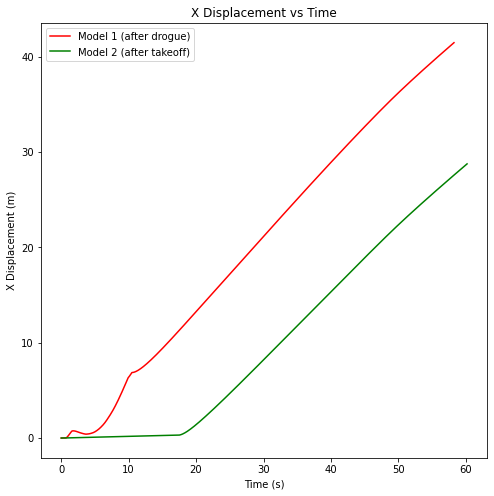

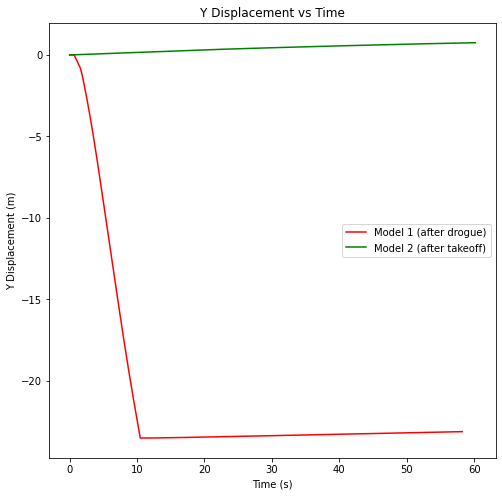

In [13]:
displacementsX, displacementsY, vectors, indices = calc_displacement(datafile, zero_out=False, my_thresh=50, my_post_drogue_delay=1, my_signal_length=3, use_time=True, my_t_sim_drogue=9.85, my_t_sim_landing=50)

x1, x2, t1, t2, y1, y2, ty1, ty2 = vectors
takeoff_time, imu_start_time, imu_end_time, landing_idx = indices
print(indices)

x1 = x1[:landing_idx]
t1 = t1[:landing_idx]
x2 = x2[:landing_idx]
t2 = t2[:landing_idx]

y1 = y1[:landing_idx]
ty1 = ty1[:landing_idx]
y2 = y2[:landing_idx]
ty2 = ty2[:landing_idx]

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(t1, x1, color='red', label='Model 1 (after drogue)')
ax.plot(t2, x2, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(ty1, y1, color='red', label='Model 1 (after drogue)')
ax.plot(ty2, y2, color='green', label='Model 2 (after takeoff)')
ax.set_title("Y Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("Y Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

(102822, 103212, 103252, 104805, [0.8370176, 0.003601620000000004])


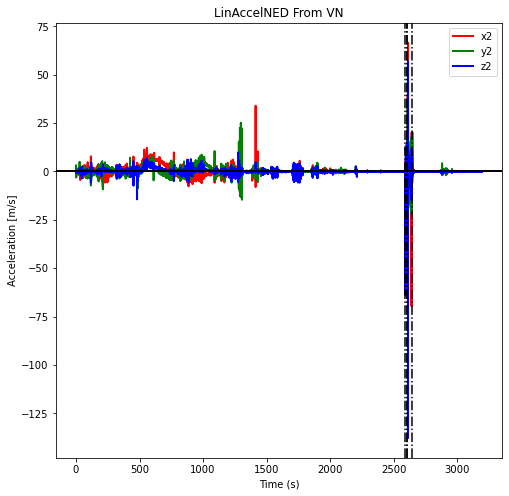

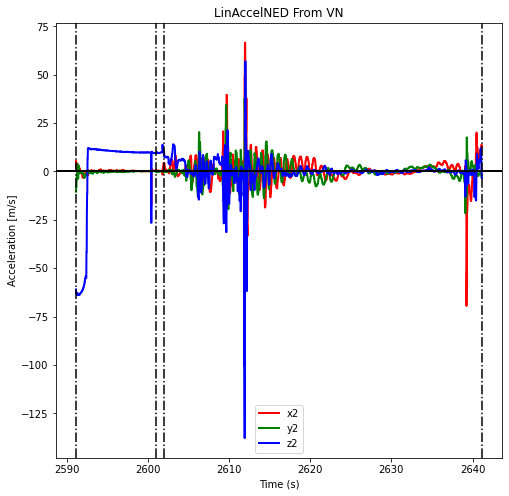

In [14]:
Full_SIFT1_datafile = "Full_SIFT1"
Full_SIFT2_datafile = "Full_SIFT2"

################## DATA FRAME ##################
datafile = '../../' + Full_SIFT2_datafile + '.csv'
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata2f = all_time
tdata2f = tdata2f - all_time[0]

ax_vn2f = df['LinearAccelNed X']
ay_vn2f = df['LinearAccelNed Y']
az_vn2f = df['LinearAccelNed Z']

a_vecf = [ax_vn2f, ay_vn2f, az_vn2f]

takeoff_idx, drogue_idx, post_drogue_idx, landing_idx, a_1 = find_peak_and_wait(a_vecf, tdata2f, thresh=50, post_drogue_delay=1, signal_length=3, time=1, t_sim_drogue=9.85, t_sim_landing=50)
print((takeoff_idx, drogue_idx, post_drogue_idx, landing_idx, a_1))

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l3 = ax.plot(tdata2f, ax_vn2f, color='red', label='x2', linewidth=2)
l3 = ax.plot(tdata2f, ay_vn2f, color='green', label='y2', linewidth=2)
l3 = ax.plot(tdata2f, az_vn2f, color='blue', label='z2', linewidth=2)
l5 = plt.axhline(y=0, color='black', linewidth=2)
#l6 = plt.axvline(tdata2[a1], color='red', linestyle='--')
l6 = plt.axvline(tdata2f[takeoff_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2f[drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2f[post_drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2f[landing_idx], color='black', linestyle='-.')
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
ax.legend()
plt.show()



fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l3 = ax.plot(tdata2f[takeoff_idx:landing_idx], ax_vn2f[takeoff_idx:landing_idx], color='red', label='x2', linewidth=2)
l3 = ax.plot(tdata2f[takeoff_idx:landing_idx], ay_vn2f[takeoff_idx:landing_idx], color='green', label='y2', linewidth=2)
l3 = ax.plot(tdata2f[takeoff_idx:landing_idx], az_vn2f[takeoff_idx:landing_idx], color='blue', label='z2', linewidth=2)
l5 = plt.axhline(y=0, color='black', linewidth=2)
#l6 = plt.axvline(tdata2[a1], color='red', linestyle='--')
l6 = plt.axvline(tdata2f[takeoff_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2f[drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2f[post_drogue_idx], color='black', linestyle='-.')
l6 = plt.axvline(tdata2f[landing_idx], color='black', linestyle='-.')
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
ax.legend()
plt.show()